In [587]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import math
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from timeit import default_timer as timer

import pydotplus
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [588]:
# Load dataset
df = pd.read_csv('winequality-white.csv')
df.rename(columns={'fixed acidity': 'fixed_acidity','citric acid':'citric_acid','volatile acidity':'volatile_acidity','residual sugar':'residual_sugar','free sulfur dioxide':'free_sulfur_dioxide','total sulfur dioxide':'total_sulfur_dioxide'}, inplace=True)


Pick a dataset of your choice with a binary outcome and the potential for at least 15 features. Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

* Vanilla logistic regression
* Ridge logistic regression
* Lasso logistic regression

If you're stuck on how to begin combining your two new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?



In [589]:
df.head(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.000,0.270,0.360,20.700,0.045,45.000,170.000,1.001,3.000,0.450,8.800,6
1,6.300,0.300,0.340,1.600,0.049,14.000,132.000,0.994,3.300,0.490,9.500,6
2,8.100,0.280,0.400,6.900,0.050,30.000,97.000,0.995,3.260,0.440,10.100,6


In [590]:
# drop rows containing outliers, using cutoffs below:
# fixed_acidity: 10.5
# volatile_acidity: .8
# citric_acid: 1
# residual_sugar: 25
# chlorides: .22
# free_sulfur_dioxide: 115
# total_sulfur_dioxide: 260
# density: 1.005
# sulphates: 1.02

drop_df = df.loc[df['sulphates'] > 1.02]
drop_df = pd.concat([drop_df, df.loc[df['density'] > 1.005]], axis = 0)
drop_df = pd.concat([drop_df, df.loc[df['total_sulfur_dioxide'] > 260]], axis = 0)
drop_df = pd.concat([drop_df, df.loc[df['free_sulfur_dioxide'] > 115]], axis = 0)
drop_df = pd.concat([drop_df, df.loc[df['chlorides'] > .22]], axis = 0)
drop_df = pd.concat([drop_df, df.loc[df['residual_sugar'] > 25]], axis = 0)
drop_df = pd.concat([drop_df, df.loc[df['citric_acid'] > 1]], axis = 0)
drop_df = pd.concat([drop_df, df.loc[df['volatile_acidity'] > .8]], axis = 0)
drop_df = pd.concat([drop_df, df.loc[df['fixed_acidity'] > 10.5]], axis = 0)

df = df.drop(drop_df.index)

df.reset_index(inplace=True)

#print(df.loc[df['sulphates'] > 1, 'sulphates'])
#print(' ')

In [591]:
df['density_mod_1'] = ((df['density'] - .9)*100)**2
df.drop('density', axis=1, inplace=True)

df['alcohol_squared'] = df['alcohol']**2
df.drop('alcohol', axis=1, inplace=True)

df['sour'] = (df['pH'] < 3.17)*1
df['pH_mod_1'] = ((df['pH'] - 2.7)*10)**2
df.drop('pH', axis=1, inplace=True)

df['dry'] = (df['residual_sugar'] < 5)*1
df['super_sweet'] = (df['residual_sugar'] > 20)*1

df['high_chlorides'] = (df['chlorides'] > .1)*1

# testing_df = df.drop('quality', axis=1)

df['high_quality'] = (df['quality'] > 6)*1

# Picking 5 SelectKBest features
#X_best = SelectKBest(f_classif, k=5).fit_transform(testing_df, df['high_quality'])
#X_best_df = pd.DataFrame({'best_1':X_best[:,0],'best_2':X_best[:,1],'best_3':X_best[:,2],'best_4':X_best[:,3],'best_5':X_best[:,4]})
#df = pd.concat([df, X_best_df], axis = 1)

df.drop('index', axis=1, inplace=True)


In [592]:
# setting up testing vs training datasets
training_fraction = .8

training_X = df.sample(frac=testing_fraction, random_state=10)
testing_X = df.drop(training_X.index)

# separate the high_quality feature out into a Y dataset
training_Y = training_X['high_quality']
testing_Y = testing_X['high_quality']

nb_training_X = training_X
nb_testing_X = testing_X
nb_training_Y = training_X['alcohol_squared']
nb_testing_Y = testing_X['alcohol_squared']

# dropping the quality and high_quality variables so that the model isn't able to cheat
training_X.drop('quality', axis=1, inplace=True)
testing_X.drop('quality', axis=1, inplace=True)
training_X.drop('high_quality', axis=1, inplace=True)
testing_X.drop('high_quality', axis=1, inplace=True)

nb_training_X.drop('alcohol_squared', axis=1, inplace=True)
nb_testing_X.drop('alcohol_squared', axis=1, inplace=True)



In [632]:
# Logistic Regression Model
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(training_X, training_Y)
print('Model score:')
print(lr.score(testing_X, testing_Y))
print('Model cross-valuation:')
print(sklearn.model_selection.cross_val_score(lr, testing_X, testing_Y, cv = 10))
origparams = np.append(lr.coef_, lr.intercept_)
print('Model coefficients & intercept:')
print(origparams)

Model score:
0.7970358172087278
Model cross-valuation:
[0.79835391 0.79423868 0.79012346 0.79423868 0.79423868 0.81069959
 0.79012346 0.79835391 0.79012346 0.79752066]
Model coefficients & intercept:
[ 0.47260705 -0.35909569  0.3515002   0.14151987 -0.99563394  0.02435474
 -0.01080452  1.56010208 -0.14921846  0.08572739  0.02605687  0.54448122
 -0.61194289 -1.0177549   6.63129912]


In [627]:
# Ridge Model
ridge = linear_model.Ridge(alpha=3)
ridge.fit(training_X, nb_training_Y)
print('Model score:')
print(ridge.score(testing_X, nb_testing_Y))
print('Model cross-valuation:')
print(sklearn.model_selection.cross_val_score(ridge, testing_X, nb_testing_Y, cv = 10))
origparams = np.append(ridge.coef_, ridge.intercept_)
print('Model coefficients & intercept:')
print(origparams)

Model score:
0.9034243103360889
Model cross-valuation:
[0.87200963 0.88138274 0.84927404 0.84680394 0.8717173  0.90154412
 0.9213259  0.89644563 0.9398283  0.90222269]
Model coefficients & intercept:
[ 1.17391151e+01  9.12483812e+00  7.48621773e+00  5.60115284e+00
  5.05623155e-01 -7.98155033e-02  4.91167571e-02  1.93233493e+01
 -8.59771378e+00 -2.22381325e+00  4.41212131e-01  7.51644091e-01
  2.55282429e+00  1.61362152e+00  7.27378641e+02]


In [626]:
# Lasso Model
lasso = linear_model.Lasso(alpha=3)
lasso.fit(training_X, nb_training_Y)
print('Model score:')
print(lasso.score(testing_X, nb_testing_Y))
print('Model cross-valuation:')
print(sklearn.model_selection.cross_val_score(lasso, testing_X, nb_testing_Y, cv = 10))
origparams = np.append(lasso.coef_, lasso.intercept_)
print('Model coefficients & intercept:')
print(origparams)

Model score:
0.8410413872727197
Model cross-valuation:
[0.81978397 0.80862618 0.71394067 0.72739814 0.78206207 0.83860251
 0.88695078 0.84449239 0.87422969 0.82018398]
Model coefficients & intercept:
[ 3.45675950e+00  0.00000000e+00  0.00000000e+00  3.78126416e+00
 -0.00000000e+00 -6.56532976e-02  1.95781045e-02  0.00000000e+00
 -6.72533009e+00 -0.00000000e+00  2.61780240e-01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  6.52037151e+02]


Features were engineered in an effort to extract more significant variations in variables that seemed to be factors in determining 'quality'. (See below for box charts regarding that relationship.)  

Regularization parameters were selected based on what caused significant drop-off in features and accuracy in the Lasso model. Accuracy drops below 90%, with 6 out of 14 features removed by the Lasso algorithm, with a lambda of 0.1; by lambda = 3, accuracy is down to 84% and feature count is down by to 6/14 remaining.  Meanwhile, the Ridge model has suffered a negligible amount of accuracy decay at the same lambda.  Both models get better with lower lambda, and their cross-valuations don't seem to improve significantly (i.e., they don't seem to suffer any less from over-fitting) at higher lambda to compensate for this loss of accuracy.

The 'nb' variables are used to test Lasso and Ridge models, as they perform extremely poorly in estimating a binary outcome like 'high_quality', or even a multiple-choice outcome like 'quality'.  However, continuous variables such as 'alcohol_squared' or 'residual_sugar' seem to be perfect choices for using those particular regression algorithms, as they both produce 90%+ accuracy rates with relatively insignificant fluctuations in the models' cross-valuation scores.

With regards to which model is "best," that's a bit of a poor choice of terms, in my view.  If we're talking about which is the best to figure out whether a given wine will be high-quality based on its chemical and physical properties, then Logistic regression is the winnner.  If we care about something that targets a continuous variable, like guessing a wine's alcohol content or how much sugar is in it, then both Ridge and Lasso are better; if the number of features are overwhelming, then Lasso wins.  If overfitting isn't a problem, then Ridge seems more robutst.

With regards to the limitations of regression as an approach... As long as I have access to all of the regression algorithms, I feel like it's a very optimizable method of predicting outcomes.  I don't think that I've really hit the limits of regression as a whole, though, merely found places (such as binary outcomes for Lasso/Ridge) where individual algorithms fail or get noticeably clunky.

The cells below are graphs & other means of sifting through and analyzing the dataset, not intended as part of the final project.

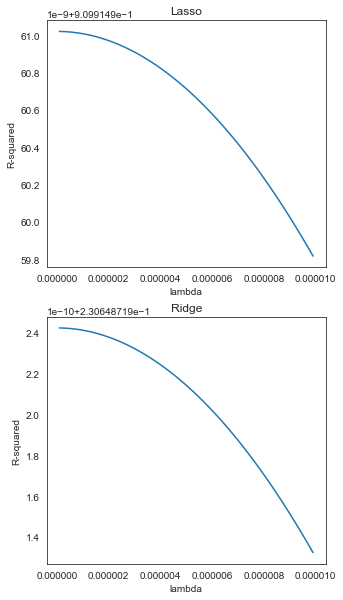

In [628]:
lasso_lambda = []
lasso_score = []
ridge_lambda = []
ridge_score = []
lambda_multiplier = .0000001

#Run the model for many alphas.
for lambd in range(1, 100, 1):
    lass = linear_model.Lasso(alpha=lambd*lambda_multiplier)
    lass.fit(training_X, nb_training_Y)
    lasso_lambda.append(lambd*lambda_multiplier)
    lasso_score.append(lass.score(training_X, nb_training_Y))
    ridgeregrBig = linear_model.Ridge(alpha=lambd*lambda_multiplier, fit_intercept=False)
    ridgeregrBig.fit(training_X, nb_training_Y)
    ridge_lambda.append(lambd*lambda_multiplier)
    ridge_score.append(ridgeregrBig.score(training_X, nb_training_Y))

lasso_graph = {'Lambda':lasso_lambda,'R Squared':lasso_score}
lasso_df = pd.DataFrame(data=lasso_graph)

ridge_graph = {'Lambda':ridge_lambda,'R Squared':ridge_score}
ridge_df = pd.DataFrame(data=ridge_graph)

# Plot a line for each parameter.
plt.figure(figsize=(5,10))
plt.subplot(2, 1, 1)
plt.plot(lasso_df['Lambda'], lasso_df['R Squared'])
plt.xlabel('lambda')
plt.ylabel('R-squared')
plt.title('Lasso')
plt.subplot(2, 1, 2)
plt.plot(ridge_df['Lambda'], ridge_df['R Squared'])
plt.xlabel('lambda')
plt.ylabel('R-squared')
plt.title('Ridge')
plt.show()

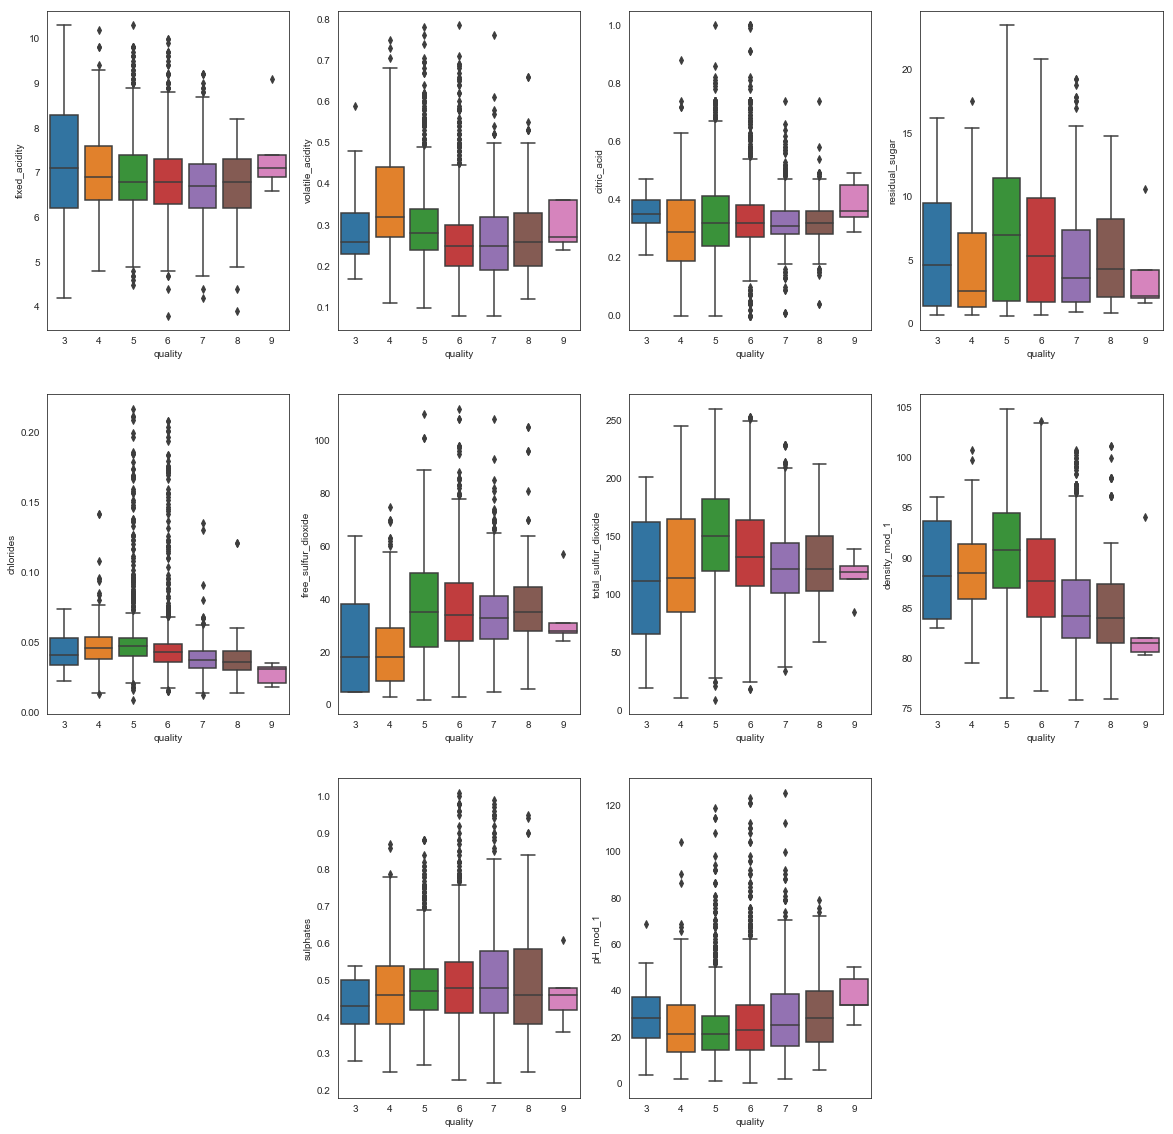

In [629]:
plt.figure(figsize=(20,20))

plt.subplot(341)
sns.boxplot(x = 'quality', y = 'fixed_acidity', data = df)

plt.subplot(342)
sns.boxplot(x = 'quality', y = 'volatile_acidity', data = df)

plt.subplot(343)
sns.boxplot(x = 'quality', y = 'citric_acid', data = df)

plt.subplot(344)
sns.boxplot(x = 'quality', y = 'residual_sugar', data = df)

plt.subplot(345)
sns.boxplot(x = 'quality', y = 'chlorides', data = df)

plt.subplot(346)
sns.boxplot(x = 'quality', y = 'free_sulfur_dioxide', data = df)

plt.subplot(347)
sns.boxplot(x = 'quality', y = 'total_sulfur_dioxide', data = df)

plt.subplot(348)
sns.boxplot(x = 'quality', y = 'density_mod_1', data = df)

plt.subplot(3,4,10)
sns.boxplot(x = 'quality', y = 'sulphates', data = df)

plt.subplot(3,4,11)
sns.boxplot(x = 'quality', y = 'pH_mod_1', data = df)



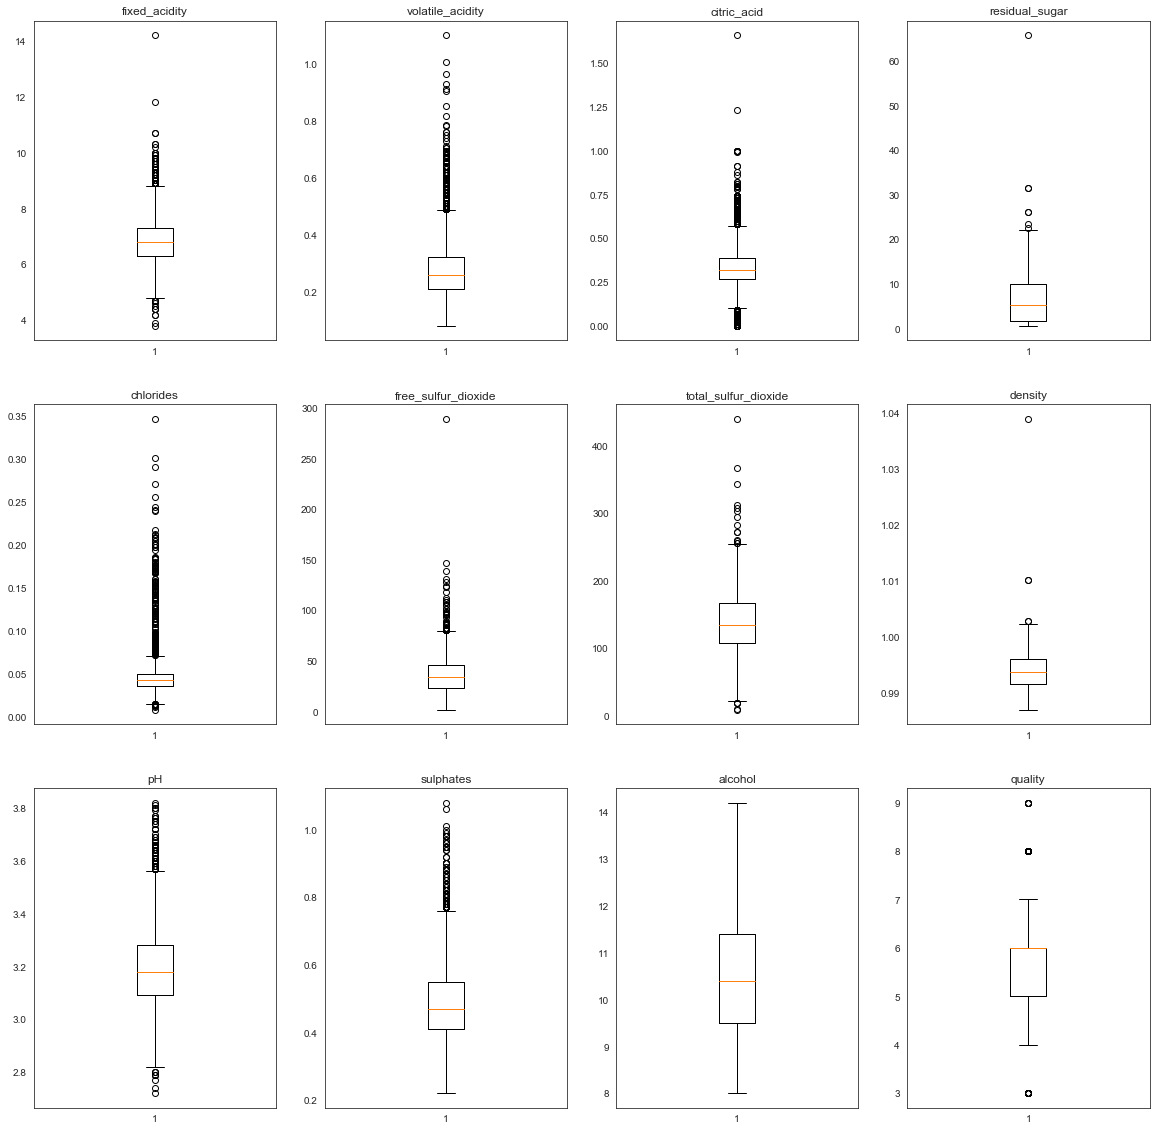

In [240]:

plt.figure(figsize=(20,20))

plt.subplot(341)
plt.boxplot(df['fixed_acidity'])
plt.title("fixed_acidity")

plt.subplot(342)
plt.boxplot(df['volatile_acidity'])
plt.title("volatile_acidity")

plt.subplot(343)
plt.boxplot(df['citric_acid'])
plt.title("citric_acid")

plt.subplot(344)
plt.boxplot(df['residual_sugar'])
plt.title("residual_sugar")

plt.subplot(345)
plt.boxplot(df['chlorides'])
plt.title("chlorides")

plt.subplot(346)
plt.boxplot(df['free_sulfur_dioxide'])
plt.title("free_sulfur_dioxide")

plt.subplot(347)
plt.boxplot(df['total_sulfur_dioxide'])
plt.title("total_sulfur_dioxide")

plt.subplot(348)
plt.boxplot(df['density'])
plt.title("density")

plt.subplot(349)
plt.boxplot(df['pH'])
plt.title("pH")

plt.subplot(3,4,10)
plt.boxplot(df['sulphates'])
plt.title("sulphates")

plt.subplot(3,4,11)
plt.boxplot(df['alcohol'])
plt.title("alcohol")

plt.subplot(3,4,12)
plt.boxplot(df['quality'])
plt.title("quality")

plt.show()


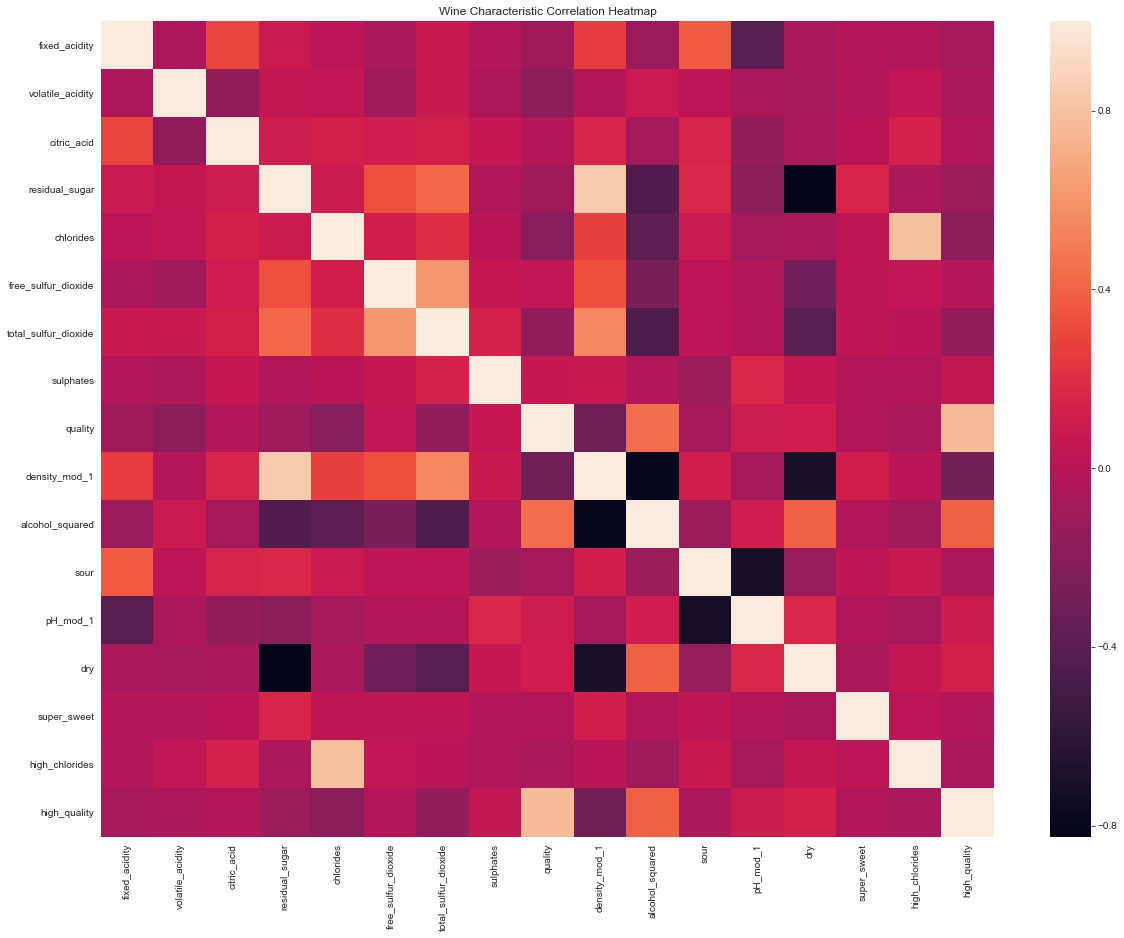

In [630]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Wine Characteristic Correlation Heatmap")
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()
